# Short Course: Machine Learning for Exploration Geophysics

Hamburg, 10. - 12. March 2020

#### Kaggle competition 1: Pseudo Sonic Log Generation

Table of Content:
- [Packages](#Packages)
- [Import the dataset](#Import-the-dataset)
- [Train-Test Split](#Train-Test-Split)
- [Create train and test datasets](#Create-train-and-test-datasets)
- [DNN model](#DNN-model)
- [Generate predictions](#Generate-predictions)
- [Save submission](#Save-submission)
- [Submit solution](#Submit-solution)

## Packages

Let's first import all the packages: 
- [numpy](https://www.numpy.org/) is the fundamental package for scientific computing with Python.
- [pandas](https://pandas.pydata.org/) is a software library for data manipulation and analysis.
- [matplotlib](https://matplotlib.org/) is a comprehensive library for creating static, animated, and interactive visualizations in Python.
- [seaborn](https://seaborn.pydata.org/) is a statistical data visualization library based on matplotlib.
- [scikit-learn](https://scikit-learn.org/stable/) is a simple and efficient tools for predictive data analysis.
- [tensorflow](https://www.tensorflow.org/) is an end-to-end open source machine learning platform. 

In [1]:
#!pip install pandas
#!pip install -U scikit-learn

#!python -m pip install -U pip
#!python -m pip install -U matplotlib

#!pip install pandas

#!pip install seaborn

#!pip install tensorflow

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import glob
import cv2
import os





import warnings
warnings.filterwarnings('ignore')

print('Pandas:  ' + pd.__version__)
print('Numpy:   ' + np.__version__)
print('Sklearn: ' + sklearn.__version__)
print(tf.__version__)

Pandas:  0.24.2
Numpy:   1.17.4
Sklearn: 0.22.2.post1
1.15.0


## Import the dataset

A comma-separated values (CSV) file is a type of plain text file that is widely supported by machine learning applications. We can read a CSV file using pandas [read_csv](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html) function into [DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html).

In [3]:
df_test = pd.read_csv('data/test_tt.csv')
df_train = pd.read_csv('data/train_tt.csv')

Let us first visualize a few examples to see what columns there are, what information they contain, how the values are coded. We could use the following methods: 

- [head(self, n)](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.head.html#pandas.DataFrame.head) - Return the first n rows,
- [info](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.info.html#pandas.DataFrame.info) - Print a concise summary of a DataFrame,
- [describe](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.describe.html#pandas.DataFrame.describe) - Generate descriptive statistics.

In [4]:
#df.head(10) #View first 10 data rows
#df.info()
df_train.describe()

,Id,X,Y,Z,Time
count,1.086557e+06,1.086557e+06,1.086557e+06,1.086557e+06,1.086557e+06
mean,5.432790e+05,2.482747e+06,5.157533e+05,6.380884e+03,1.714223e+00
std,3.136621e+05,7.964479e+03,8.546391e+03,3.839015e+03,4.921404e-01
min,1.000000e+00,2.469000e+06,5.010000e+05,-2.140000e+02,5.364813e-03
25%,2.716400e+05,2.475900e+06,5.084000e+05,3.086000e+03,1.364421e+00
50%,5.432790e+05,2.482700e+06,5.158000e+05,6.386000e+03,1.690686e+00
75%,8.149180e+05,2.489600e+06,5.232000e+05,9.686000e+03,2.063728e+00
max,1.086557e+06,2.496500e+06,5.305000e+05,1.298600e+04,3.457245e+00


In [5]:
df_test.describe()

,Id,X,Y,Z
count,1.086558e+06,1.086558e+06,1.086558e+06,1.086558e+06
mean,5.432795e+05,2.482751e+06,5.157449e+05,6.385062e+03
std,3.136624e+05,7.972032e+03,8.544473e+03,3.840939e+03
min,1.000000e+00,2.469000e+06,5.010000e+05,-2.140000e+02
25%,2.716402e+05,2.475800e+06,5.083000e+05,3.086000e+03
50%,5.432795e+05,2.482800e+06,5.157000e+05,6.386000e+03
75%,8.149188e+05,2.489700e+06,5.231000e+05,9.686000e+03
max,1.086558e+06,2.496500e+06,5.305000e+05,1.298600e+04


In [6]:
feature_names = df_train.columns[:-1].tolist()
print(feature_names)
label_names = df_train.columns[-1:].tolist()
print(label_names)

['Id', 'X', 'Y', 'Z']
['Time']


## Plot pairwise relationships in the dataset

Let us plot pairwise relationships in a dataset. [seaborn.pairplot](https://seaborn.pydata.org/generated/seaborn.pairplot.html?highlight=pairplot#seaborn.pairplot) function creates a grid of Axes such that each numeric variable in data will by shared in the y-axis across a single row and in the x-axis across a single column. The diagonal Axes are treated differently, drawing a plot to show the univariate distribution of the data for the variable in that column.

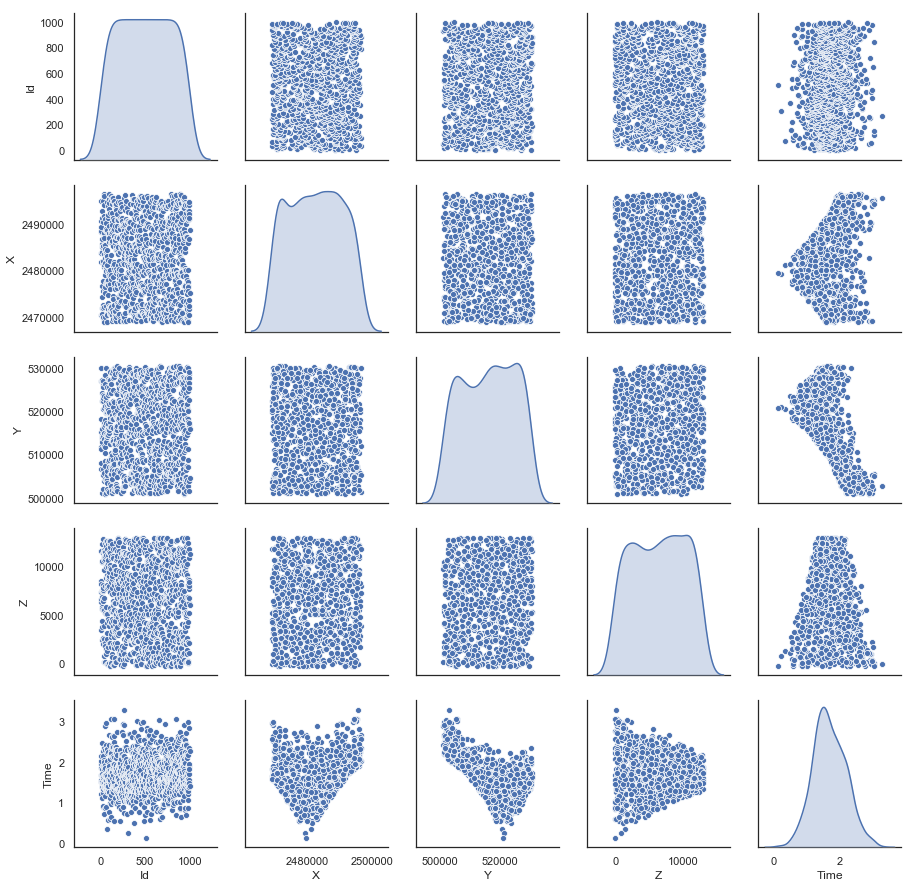

In [7]:
sns.set()
sns.set_style("white")
sns.pairplot(df_train[1:1000], diag_kind="kde")

## Train-Test Split

Let us split the data into random train and test subsets. In scikit-learn a random split into training and test sets can be quickly computed with the [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)  helper function.

In [8]:
X_train_orig = df_train[["X", "Y", "Z"]]
X_test_orig  = df_test[["X", "Y", "Z"]]
Y_train_orig = df_train["Time"]

X_train_orig = np.asarray(X_train_orig)
Y_train_orig = np.asarray(Y_train_orig)
X_test_orig = np.asarray(X_test_orig)

print('Size of the X_train dataset: ' + str(X_train_orig.shape))
print('Size of the y_train dataset: ' + str(Y_train_orig.shape))
print('Size of the X_test dataset: ' + str(X_test_orig.shape))

Size of the X_train dataset: (1086557, 3)
Size of the y_train dataset: (1086557,)
Size of the X_test dataset: (1086558, 3)


## Data preprocessing 

The [sklearn.preprocessing](https://scikit-learn.org/stable/modules/preprocessing.html) package provides several common utility functions and transformer classes to change raw feature vectors into a representation that is more suitable for the downstream estimators. In general, learning algorithms benefit from standardization of the data set. If some outliers are present in the set, robust scalers or transformers are more appropriate. 

Let us now scale the data. We will use [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) from sklearn library.

The transformation is given by:

> X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0)) 

> X_scaled = X_std * (max - min) + min

In [9]:
scaler = MinMaxScaler(feature_range=(-1, 1), copy=True)
scaler.fit(X_train_orig)
print("Maximum values of X_train (X, Y, Z): " + str(scaler.data_max_))
print("Minimum values of X_train (X, Y, Z): " + str(scaler.data_min_))

# Use the same transform for both train and test data:
X_train_norm = scaler.transform(X_train_orig)
X_test_norm = scaler.transform(X_test_orig)

Maximum values of X_train (X, Y, Z): [2496500.  530500.   12986.]
Minimum values of X_train (X, Y, Z): [ 2.469e+06  5.010e+05 -2.140e+02]


## Create train and test datasets

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X_train_norm, Y_train_orig, test_size=0.2)
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(869245, 3)
(869245,)
(217312, 3)
(217312,)


## DNN model

In [11]:
model = keras.Sequential([
    keras.layers.Dense(64, input_dim=3, activation='relu'),
    keras.layers.Dense(32, activation="relu"),
    keras.layers.Dense(1, activation="linear")
])

print(model.summary())

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                256       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 2,369
Trainable params: 2,369
Non-trainable params: 0
_________________________________________________________________
None


In [12]:
model.compile(optimizer='adam',
              loss='MSE',
              metrics=['MAE'])

In [13]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=1024, epochs=30)

Train on 869245 samples, validate on 217312 samples
Epoch 1/30
869245/869245 [==============================] - 2s 3us/sample - loss: 0.1029 - mean_absolute_error: 0.1469 - val_loss: 0.0069 - val_mean_absolute_error: 0.0577
Epoch 2/30
869245/869245 [==============================] - 2s 3us/sample - loss: 0.0035 - mean_absolute_error: 0.0399 - val_loss: 0.0014 - val_mean_absolute_error: 0.0254
Epoch 3/30
869245/869245 [==============================] - 2s 3us/sample - loss: 7.3824e-04 - mean_absolute_error: 0.0184 - val_loss: 3.9279e-04 - val_mean_absolute_error: 0.0141
Epoch 4/30
869245/869245 [==============================] - 2s 3us/sample - loss: 2.6473e-04 - mean_absolute_error: 0.0117 - val_loss: 1.8858e-04 - val_mean_absolute_error: 0.0101
Epoch 5/30
869245/869245 [==============================] - 2s 3us/sample - loss: 1.5759e-04 - mean_absolute_error: 0.0093 - val_loss: 1.3286e-04 - val_mean_absolute_error: 0.0087
Epoch 6/30
869245/869245 [==============================] - 2s 3

In [14]:
test_loss, test_acc = model.evaluate(X_val, y_val, verbose=0)
print('\nTest loss:', test_loss)
print('\nTest accuracy:', test_acc)


Test loss: 2.765798200341741e-05

Test accuracy: 0.0041008913


In [15]:
print('\nhistory dict:', history.history.keys())


history dict: dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])


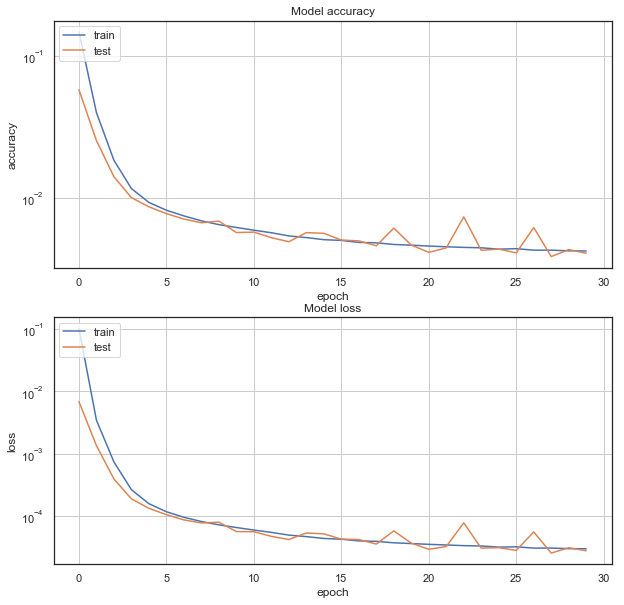

In [16]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.yscale('log')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.subplot(2, 1, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.yscale('log')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

## Generate predictions

In [17]:
predictions = model.predict(X_test_norm)

## Save submission

In [18]:
sample_submission = pd.read_csv('data/sample_submission_tt.csv')

new_submission = sample_submission
new_submission["Predicted"] = predictions

filename = 'new_submission_example.csv'
new_submission.to_csv(filename,index=False)
print('Saved file: ' + filename)

Saved file: new_submission_example.csv


## Submit solution

In [ ]:
#kaggle competitions submit -c ml-for-exploration-geophysics-dnn -f new_submission_example.csv -m "Message"